# QOSF - Screening Task-2

Implement a circuit that returns $\lvert01\rangle$ and $\lvert10\rangle$ with equal probability.

**Requirements:**
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

**Bonus question:
How to make sure you produce state $\lvert01\rangle$ + $\lvert10\rangle$ and not $\lvert01\rangle$ - $\lvert10\rangle$?**

# Solution:

## Contents:

1. [Usual Approach](#first)
2. [Usual Approach with Rx-Ry-CNOT combination](#second)
3. [Randomly Parametrized Circuit](#third)
4. [Gradient Descent](#fourth)
5. [Optimization](#fifth)
6. [Complete Circuit](#six)
7. [Comparison](#seven)    
[Summary](#summary)    
[References](#ref)

### 0. Importing necessary libraries

In [1]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.visualization import *
import numpy as np
from numpy import pi
import random
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import clear_output

---

<a id='first'></a>
### 1. The Usual Approach:
A standard circuit that implements the bell state: $\frac{1}{\sqrt{2}} (\lvert01\rangle + \lvert10\rangle)$ is as follows:

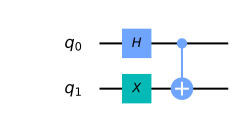

In [2]:
std_cirq=QuantumCircuit(2)

std_cirq.h(0)  # Hadamard gate on q0
std_cirq.x(1)  # X gate on q1
std_cirq.cx(0,1)  # CNOT on q1 controlled on q0
std_cirq.draw('mpl')

#### Plotting on the Q-sphere

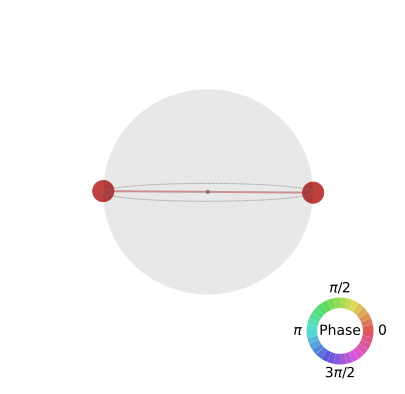

In [3]:
sv = Statevector.from_label('00').evolve(std_cirq)
plot_state_qsphere(sv.data)

#### Plotting the histogram:

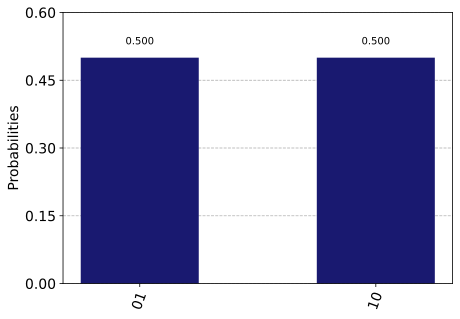

In [46]:
backend = Aer.get_backend('statevector_simulator')
state = execute(std_cirq,backend).result().get_statevector()
results = execute(std_cirq,backend).result().get_counts()
plot_histogram(results, color='midnightblue')

---

<a id='second'></a>
## 2. The Usual Approach with RX-RY-CNOT combination:

With restrictions from our task-2;

**Condition-1: The circuit can contain only CNOTs, RXs and RYs.**

**Approach:**    
Since we know the exact circuit that gives us this state, where $\lvert01\rangle$ and $\lvert10\rangle$ are in equal probabilities, it is easy to formulate the usual gates into a combination of RXs, RYs and CNOTs with appropriate angle values to give us the exact results.

<img src="img/circuit.jpeg">  

Where $|\psi_0\rangle,|\psi_1\rangle$ and $|\psi_2\rangle$ are the intermediate steps of reaching up to the final state $|\psi\rangle$

**Calculating the angle values for `Rx` and `Ry` gates in the above circuit:**    

We know that:    
We have to generate equal probabilities of $|01\rangle$ and $|10\rangle$ in state $|\psi\rangle = \alpha\lvert01\rangle + \beta\lvert10\rangle$
i.e.,

$$
\left\lVert\alpha^2\right\rVert = \left\lVert\beta^2\right\rVert = 0.5
$$
and hence, $\alpha = \beta = \frac{1}{\sqrt{2}}$

The unitary matrices for $RY(\theta_1)$ and $RX(\theta_2)$ gates are given by:
$$
\begin{aligned}
    RY(\theta_1) & = 
    \begin{bmatrix} 
        cos(\frac{\theta_1}{2}) & -sin(\frac{\theta_1}{2}) \\ 
        sin(\frac{\theta_1}{2}) & cos(\frac{\theta_1}{2})
    \end{bmatrix}\\
    RX(\theta_2) & = 
    \begin{bmatrix} 
        cos(\frac{\theta_2}{2}) & -isin(\frac{\theta_2}{2}) \\ 
        -isin(\frac{\theta_2}{2}) & cos(\frac{\theta_2}{2})
    \end{bmatrix}\\
\end{aligned}
$$

**As we see in the diagram:**

$$
\begin{aligned}
    |\psi\rangle &= \alpha|01\rangle + \beta|10\rangle \\
    |\psi_2\rangle &= CNOT |\psi\rangle \\
    &= \alpha|01\rangle + \beta|11\rangle \\
    &= \lgroup\alpha|0\rangle + \beta|1\rangle\rgroup \otimes |1\rangle \\
\end{aligned}
$$

The last statement sets both the qubits in a completely separable state, so we can optimize them individually.

**Applying the gates on $q_0$:**

$$
\begin{aligned}
    |q_0\rangle &=
    \begin{bmatrix}
        \cos\frac{\theta_2}{2} & -i\sin\frac{\theta_2}{2} \\
        -i\sin\frac{\theta_2}{2} & \cos\frac{\theta_2}{2} 
    \end{bmatrix}\cdot
    \begin{bmatrix}
        \cos\frac{\theta_1}{2} & -\sin\frac{\theta_1}{2} \\
        \sin\frac{\theta_1}{2} & \cos\frac{\theta_1}{2} 
    \end{bmatrix}\cdot
    \begin{bmatrix}
        1 \\
        0  
    \end{bmatrix} \\
    &= \begin{bmatrix}
        \cos\frac{\theta_2}{2} & -i\sin\frac{\theta_2}{2} \\
        -i\sin\frac{\theta_2}{2} & \cos\frac{\theta_2}{2} 
    \end{bmatrix}\cdot
    \begin{bmatrix}
        \cos\frac{\theta_1}{2} \\
        \sin\frac{\theta_1}{2}  
    \end{bmatrix} \\
    &= \begin{bmatrix}
        \cos\frac{\theta_2}{2}\cos\frac{\theta_1}{2} - i\sin\frac{\theta_2}{2}\sin\frac{\theta_1}{2}  \\
        \cos\frac{\theta_2}{2}\sin\frac{\theta_1}{2} - i\sin\frac{\theta_2}{2}\cos\frac{\theta_1}{2} 
    \end{bmatrix} \\
\end{aligned}
$$

**Equating with values of $\alpha$ and $\beta$**
$$
\begin{aligned}
    \begin{bmatrix}
        \cos\frac{\theta_2}{2}\cos\frac{\theta_1}{2} - i\sin\frac{\theta_2}{2}\sin\frac{\theta_1}{2}  \\
        \cos\frac{\theta_2}{2}\sin\frac{\theta_1}{2} - i\sin\frac{\theta_2}{2}\cos\frac{\theta_1}{2} 
    \end{bmatrix}
    &= \begin{bmatrix}
        \frac{1}{\sqrt{2}} \\
        \frac{1}{\sqrt{2}}  
    \end{bmatrix} \\
\end{aligned}
$$

We get:

$$
\begin{aligned}
    \cos\frac{\theta_2}{2}\cos\frac{\theta_1}{2} &= \frac{1}{\sqrt{2}}, \\
    \cos\frac{\theta_2}{2}\sin\frac{\theta_1}{2} &= \frac{1}{\sqrt{2}},
\end{aligned}
$$
and
$$
\begin{aligned}
    \sin\frac{\theta_2}{2}\sin\frac{\theta_1}{2} &= 0 \\
    \sin\frac{\theta_2}{2}\cos\frac{\theta_1}{2} &= 0
\end{aligned}
$$
Solving the above, we get: $\theta_1 = \frac{\pi}{2}$; $\theta_2 = \pi$

**Applying the $Rx(\theta_3)$ gate to get an effect of X gate on $q_1$:**

i.e., $Rx(\theta_3) * |0\rangle = |1\rangle$

$$
\begin{aligned}
    \begin{bmatrix} 
        \cos(\frac{\theta_3}{2}) & -i\sin(\frac{\theta_3}{2}) \\ 
        -i\sin(\frac{\theta_3}{2}) & \cos(\frac{\theta_3}{2}) 
    \end{bmatrix} \cdot
    \begin{bmatrix}
        1 \\
        0  
    \end{bmatrix}
    & = \begin{bmatrix}
        0 \\
        1  
    \end{bmatrix} \\
    \begin{bmatrix} 
        \cos(\frac{\theta_3}{2}) \\ 
        -i\sin(\frac{\theta_3}{2}) 
    \end{bmatrix}
    & = \begin{bmatrix}
        0 \\
        1  
    \end{bmatrix}
\end{aligned}
$$

Apply a global phase `i` on RHS, and we get:

$$
\begin{aligned}    
    \begin{bmatrix} 
        \cos(\frac{\theta_3}{2}) \\ 
        -i\sin(\frac{\theta_3}{2}) 
    \end{bmatrix}
    & = \begin{bmatrix}
        0 \\
        i  
    \end{bmatrix}
\end{aligned}
$$

Solving the above, we get: $\theta_3 = \pi$

Putting these angle values of $\theta_1$, $\theta_2$ and $\theta_3$ in a quantum circuit:

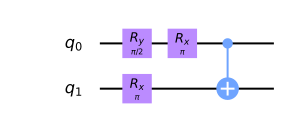

In [5]:
# Initializing a 2-qubit quantum circuit
cirq = QuantumCircuit(2)

#===================================================================
# Replicating the usual approach circuit with Rx, Ry and CNOT gates
#===================================================================

# An Ry gate with theta=pi/2 + an Rx gate with theta=pi; works like a Hadamard on q0
cirq.ry(np.pi/2, 0) 
cirq.rx(np.pi, 0)

# An Rx gate with theta=pi; works like an X gate on q1
cirq.rx(np.pi, 1)

# Since there is no restriction on using CNOT gate we can use that like the usual approach; applied on q1 and controlled on q0.
cirq.cx(0,1)

# Visualize the circuit
cirq.draw('mpl')

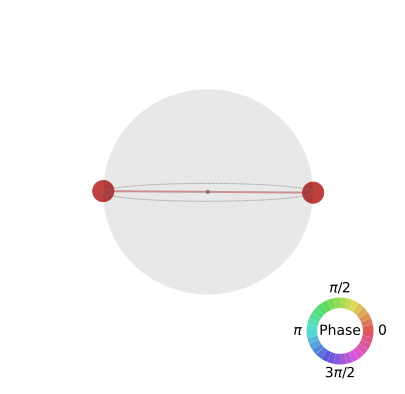

In [6]:
# evolving the Statevector() using the QuantumCircuit() to reach the final state
sv = Statevector.from_label('00').evolve(cirq)
plot_state_qsphere(sv.data)

___

<a id='third'></a>
## 3. Randomly Parametrized circuit

**Condition-2: Start from all parameters in parametric gates being equal to 0 or randomly chosen.**

Approach: Define a static circuit with parametrized gates and pass random theta values.

In [7]:
# Static circuit with 2 qubits with Ry and Rx parametrized gates along with CNOT applied
# The function takes in two lists of theta values for gates applied on qubit 0 and qubit 1

def circuit(theta_q0, theta_q1):
    cirq = QuantumCircuit(2)
    cirq.ry(theta_q0[0], 0)    # q0 - gate Ry
    cirq.rx(theta_q0[1], 0)    # q0 - gate Rx
    cirq.ry(theta_q1[0], 1)    # q1 - gate Ry
    cirq.rx(theta_q1[1], 1)    # q1 - gate Rx
    cirq.cx(0, 1)              # q1 - gate CNOT (controlled on 0)
    cirq.measure_all()         # measurement
    return cirq

Preparing random theta values and passing on in the circuit. The above function takes two parameters for angles, defining their values

In [8]:
theta_q0 = 2 * np.pi * np.random.rand(2)
theta_q1 = 2 * np.pi * np.random.rand(2)

Passing the random theta values in the circuit function and visualising

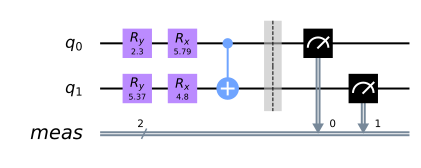

In [9]:
cirq = circuit(theta_q0, theta_q1)    # calling circuit function
cirq.draw('mpl')                      # Visualizing the resultant circuit

___

**Condition-3: You should find the right set of parameters using gradient descent**

This is an attempt to implement gradient descent from scratch.   
Since we have separable qubits, we will optimize one qubit at a time.

In [10]:
def single_qbit_circuit(theta, measure=True):
    circuit = QuantumCircuit(1)
    circuit.ry(theta[0], 0)
    circuit.rx(theta[1], 0)
    if measure:
        circuit.measure_all()
    return circuit

As per the above function, on both q0 and q1, the initial state $|0\rangle$ would be followed by an `Ry` and an `Rx` gate.

That means:

$$
\begin{aligned}
    |q\rangle &=
    \begin{bmatrix}
        \cos\frac{\theta_2}{2} & -i\sin\frac{\theta_2}{2} \\
        -i\sin\frac{\theta_2}{2} & \cos\frac{\theta_2}{2} 
    \end{bmatrix}\cdot
    \begin{bmatrix}
        \cos\frac{\theta_1}{2} & -\sin\frac{\theta_1}{2} \\
        \sin\frac{\theta_1}{2} & \cos\frac{\theta_1}{2} 
    \end{bmatrix}\cdot
    \begin{bmatrix}
        1 \\
        0  
    \end{bmatrix} \\
    &= \begin{bmatrix}
        \cos\frac{\theta_1}{2}\cos\frac{\theta_2}{2} - i\sin\frac{\theta_1}{2}\sin\frac{\theta_2}{2}  \\
        \sin\frac{\theta_1}{2}\cos\frac{\theta_2}{2} - i\cos\frac{\theta_1}{2}\sin\frac{\theta_2}{2} 
    \end{bmatrix}
\end{aligned}
$$

So, the final state's amplitudes can be written as:

$$
\begin{aligned}
   \lvert\psi\rangle = \lgroup\cos\frac{\theta_1}{2}\cos\frac{\theta_2}{2} - i\sin\frac{\theta_1}{2}\sin\frac{\theta_2}{2}\rgroup\lvert0\rangle + \lgroup\sin\frac{\theta_1}{2}\cos\frac{\theta_2}{2} - i\cos\frac{\theta_1}{2}\sin\frac{\theta_2}{2}\rgroup\lvert1\rangle 
\end{aligned}
$$

### Probabilities:

$$
\begin{aligned}
   P_0 = \langle0|\psi\rangle &= 
   |\cos\frac{\theta_1}{2}\cos\frac{\theta_2}{2} - i\sin\frac{\theta_1}{2}\sin\frac{\theta_2}{2}|^2 \\
    P_0 &= \cos^2\frac{\theta_1}{2}\cos^2\frac{\theta_2}{2} + \sin^2\frac{\theta_1}{2}\sin^2\frac{\theta_2}{2} \\
\end{aligned}
$$
Similarly,
$$
\begin{aligned}
   P_1 = \langle1|\psi\rangle &= 
   |\sin\frac{\theta_1}{2}\cos\frac{\theta_2}{2} - i\cos\frac{\theta_1}{2}\sin\frac{\theta_2}{2}|^2 \\
   P_1 &= \sin^2\frac{\theta_1}{2}\cos^2\frac{\theta_2}{2} + \cos^2\frac{\theta_1}{2}\sin^2\frac{\theta_2}{2} \\
\end{aligned}   
$$

### Cost Function:

The cost function is the distance between the actual and the predicted.

Formla: 

<img src="img/costfunction.jpeg">  

In our case, we treat both qubits separately, so we have separate cost functions for both. We expect the gates applied on q0 to behave like Hadamard, tha means it should end up with equal superpositioned states of $|0\rangle$ and $|1\rangle$ (i.e. both states with probability = 0.5). So, in case of q0, actual probability taken as 0.5 for each as per expectation. Whereas, on q1 we want our gates to act like an X gate, flipping the original initial state of $|0\rangle$ to $|1\rangle$. So for q1, $P_0 = 0$ and $P_1 = 1$.

So, on q0:

$$
\begin{aligned}
    CF_0 &= \displaystyle\frac{1}{2*2}\sum\limits_{1}^2 (P_i - 0.5)^2 \\
    &= \frac{1}{2} (P_0 - 0.5)^2 + \frac{1}{2} (P_1 - 0.5)^2 \\
    &= (P_0 - 0.5)^2 \\
    &[\because P_0 + P_1 = 1]
\end{aligned}
$$

And, on q1:

$$
\begin{aligned}
    CF_1 &= \displaystyle\frac{1}{2} (P_0 - 0)^2 + \frac{1}{2} (P_1 - 1)^2 \\
    &= P_0^2
\end{aligned}
$$

In [11]:
def cost_function_q0 (P0, P1):
    cf1 = (P0 - 0.5) ** 2
    return cf1

def cost_function_q1 (P0, P1):
    cf2 = P0 ** 2
    return cf2

<a id='fourth'></a>
## 4. Gradient Descent:

During optimization, gradient descent changes each parameter by the value of partial derivative of the cost function for that particular parameter at given point. So, finding partial derivatives of the cost functions:

For q0:

$$
\begin{aligned}
    \frac{\partial CF_0}{\partial \theta} &= 2 * (P_0 - 0.5) * \frac{\partial P_0}{\partial \theta}
\end{aligned}
$$

For q1:

$$
\begin{aligned}
    \frac{\partial CF_1}{\partial \theta} &= 2 * P_0 * \frac{\partial P_0}{\partial \theta}
\end{aligned}
$$

We are treating each qubit with two theta values. So, finding solving $\frac{\partial P_0}{\partial \theta}$ and $\frac{\partial P_1}{\partial \theta}$ for $\theta_1$ and $\theta_2$:

For $P_0$ on $\theta_1$ and $\theta_2$:

$$
\begin{aligned}
    \frac{\partial P_0}{\partial \theta_1} & = -\sin\theta_1\cos^2\frac{\theta_2}{2} + \sin\theta_1\sin^2\frac{\theta_2}{2} \\
    & = -\sin\theta_1\big(\cos^2\frac{\theta_2}{2} - \sin^2\frac{\theta_2}{2}\big) \\
    & = -\sin\theta_1\cos\theta_2 \\
    \frac{\partial P_0}{\partial \theta_2} & = -\cos^2\frac{\theta_1}{2}\sin\theta_2 + \sin^2\frac{\theta_1}{2}\sin\theta_2 \\
    & = -\cos\theta_1\sin\theta_2 \\
\end{aligned}
$$

For $P_1$ on $\theta_1$ and $\theta_2$:

$$
\begin{aligned}
    \frac{\partial P_1}{\partial \theta_1} & = \cos^2\frac{\theta_2}{2}\sin\theta_1 - \sin^2\frac{\theta_2}{2}\sin\theta_1 \\
    & = \sin\theta_1\cos\theta_2 \\
    \frac{\partial P_1}{\partial \theta_2} & = -\sin^2\frac{\theta_1}{2}\sin\theta_2 + \cos^2\frac{\theta_1}{2}\sin\theta_2 \\
    & = \cos\theta_1\sin\theta_2 \\
\end{aligned}
$$

Substituting the values in above equations for $\frac{\partial CF_0}{\partial \theta}$ and $\frac{\partial CF_1}{\partial \theta}$ for both $\theta_1$ and $\theta_2$:

For q0:

$$
\begin{aligned}
    \frac{\partial CF_0}{\partial \theta_1} &= \sin\theta_1 \cos\theta_2 \lgroup P_1 - P_0 \rgroup \\
    \frac{\partial CF_0}{\partial \theta_2} &= \sin\theta_2 \cos\theta_1 \lgroup P_1 - P_0 \rgroup
\end{aligned}
$$

For q1:

$$
\begin{aligned}
    \frac{\partial CF_1}{\partial \theta_1} &= \sin\theta_1 \cos\theta_2 \lgroup P_1 - P_0 -1 \rgroup \\
    \frac{\partial CF_1}{\partial \theta_2} &= \sin\theta_2 \cos\theta_1 \lgroup P_1 - P_0 -1 \rgroup
\end{aligned}
$$

Defining gradient functions for q0 and q1:

In [12]:
def gradient_q0(learning_rate, theta, P0, P1):
    g_q0 = np.sin(theta[0]) * np.cos(theta[1]) * (P1 - P0)
    g_q1 = np.sin(theta[1]) * np.cos(theta[0]) * (P1 - P0)
    gd_q0 = [learning_rate * g_q0, learning_rate * g_q1]
    return gd_q0

def gradient_q1(learning_rate, theta, P0, P1):
    g_q0 = np.sin(theta[0]) * np.cos(theta[1]) * (P1 - P0 - 1)
    g_q1 = np.sin(theta[1]) * np.cos(theta[0]) * (P1 - P0 - 1)
    gd_q1 = [learning_rate * g_q0, learning_rate * g_q1]
    return gd_q1

**Function to calculate probabilities:**

In [13]:
def probabilities (backend, result, shots):
    if backend == qasm:
        counts = result.get_counts()
    elif backend == sv_sim:
        counts = Statevector(result.get_statevector()).probabilities_dict()
    try:
        P0 = counts['0'] / shots
    except:
        P0 = 0
    try:
        P1 = counts['1'] / shots
    except:
        P1 = 0
    return (P0, P1)

Defining variables: learning rate, total number of steps and list with different number of shots.

In [14]:
lr = 0.1
total_steps = 1000
shots = [1, 10, 100, 1000] 

Getting a progress bar:

In [15]:
def progress_bar(iteration):
    progress = iteration / total_steps
    current_length = int(50 * progress)
    output = "\rProgress: [{0}] {1:.1f}%".format("+" * current_length + "-" * (50 - current_length), 100 * progress)
    return output

**Defining a function to optimize the angle values using Gradient Descent:**

In [16]:
def angle_optimizer(circuit_creator, measure, backend, shots, compute_gradient, compute_cost):
    costs = []
    if backend == qasm:
        noise = noise_model
    else:
        noise = None
    theta = 2 * np.pi * np.random.rand(2)   # Generate a circuit with random parameters
    circuit = circuit_creator(theta)
    print("Running Gradient Descent Optimizer with shots = {} :".format(shots))
    for iteration in range(1, total_steps + 1):
        result = execute(circuit, backend=backend, shots=shots, noise_model=noise).result()
        (P0, P1) = probabilities(backend, result, shots)
        cost = compute_cost(P0, P1)
        costs.append(cost)
        delta = compute_gradient(lr, theta, P0, P1)    # Compute Gradient
        theta = theta - delta    # Update angles
        print(progress_bar(iteration), end='')
        circuit = circuit_creator(theta, measure)
    print("\n\n*********************************************************************************\n")
    return circuit, theta, costs

Plotting a graph to visualize effectively:

In [17]:
def plot_graphs(results):

    print("Iterations vs Cost")

    fig, ax = plt.subplots(4)
    fig.set_size_inches(10,10)  # 8,8
    fig.set_tight_layout(5.0)

    for idx, result in enumerate(results):

        final_state = Statevector.from_label('0').evolve(result['circuit'].remove_final_measurements(inplace=False))

        probabilities = final_state.probabilities_dict()
        P0 = probabilities['0'] if '0' in probabilities else 0
        P1 = probabilities['1'] if '1' in probabilities else 0

        ax[idx].set_title("Qubit 0 | {} measurement shot(s) per iteration | P0 = {:.4f} | P1 = {:.4f}"\
                          .format(result['shots'], P0, P1))
        ax[idx].plot(list(range(total_steps)), result['costs'], label='Cost')

**Loading necessary backend options and noise_model**

In [18]:
from qiskit import Aer, IBMQ
from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.load_account()

In [19]:
qasm = Aer.get_backend('qasm_simulator')
sv = Aer.get_backend('statevector_simulator')
backend = provider.get_backend('ibmq_valencia')
noise_model = NoiseModel.from_backend(backend)

**Condition-4: Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise.**

<a id='fifth'></a>
## 5. Optimization

**Executing the gradient descent optimizer to get optimized angles for first qubit, q0, so as to achieve the state $\frac{1}{\sqrt{2}} |0\rangle + \frac{1}{\sqrt{2}} |1\rangle$:**

In [20]:
q0 = []

for num_shots in shots:
    q0_circuit, q0_thetas, q0_costs = angle_optimizer(single_qbit_circuit, 
                                                      True,
                                                      qasm, 
                                                      num_shots, 
                                                      gradient_q0, 
                                                      cost_function_q0)
    q0.append({'shots': num_shots, 'circuit': q0_circuit, 'angles': q0_thetas, 'costs': q0_costs})

Running Gradient Descent Optimizer with shots = 1 :
Progress: [++++++++++++++++++++++++++++++++++++++++++++++++++] 100.0%

*********************************************************************************

Running Gradient Descent Optimizer with shots = 10 :
Progress: [++++++++++++++++++++++++++++++++++++++++++++++++++] 100.0%

*********************************************************************************

Running Gradient Descent Optimizer with shots = 100 :
Progress: [++++++++++++++++++++++++++++++++++++++++++++++++++] 100.0%

*********************************************************************************

Running Gradient Descent Optimizer with shots = 1000 :
Progress: [++++++++++++++++++++++++++++++++++++++++++++++++++] 100.0%

*********************************************************************************



Iterations vs Cost


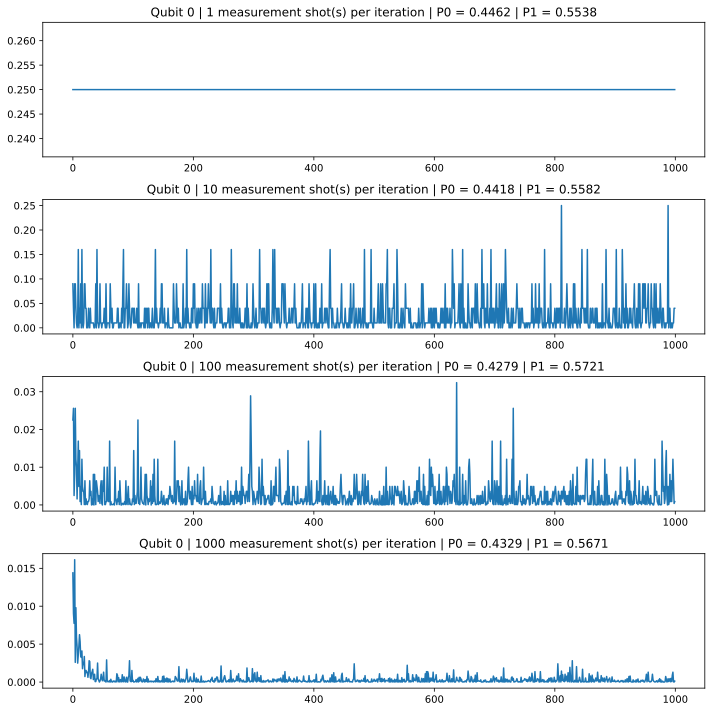

In [21]:
plot_graphs(q0)

**Executing the gradient descent optimizer to get optimized angles for second qubit, q1, such that we get a state $|1\rangle$:**

In [22]:
q1 = []
for num_shots in shots:
    q1_circuit, q1_theta, q1_costs = angle_optimizer(single_qbit_circuit, True, qasm, num_shots, gradient_q1, cost_function_q1)
    q1.append({'shots': num_shots, 'circuit': q1_circuit, 'angles': q1_theta, 'costs': q1_costs})

Running Gradient Descent Optimizer with shots = 1 :
Progress: [++++++++++++++++++++++++++++++++++++++++++++++++++] 100.0%

*********************************************************************************

Running Gradient Descent Optimizer with shots = 10 :
Progress: [++++++++++++++++++++++++++++++++++++++++++++++++++] 100.0%

*********************************************************************************

Running Gradient Descent Optimizer with shots = 100 :
Progress: [++++++++++++++++++++++++++++++++++++++++++++++++++] 100.0%

*********************************************************************************

Running Gradient Descent Optimizer with shots = 1000 :
Progress: [++++++++++++++++++++++++++++++++++++++++++++++++++] 100.0%

*********************************************************************************



Iterations vs Cost


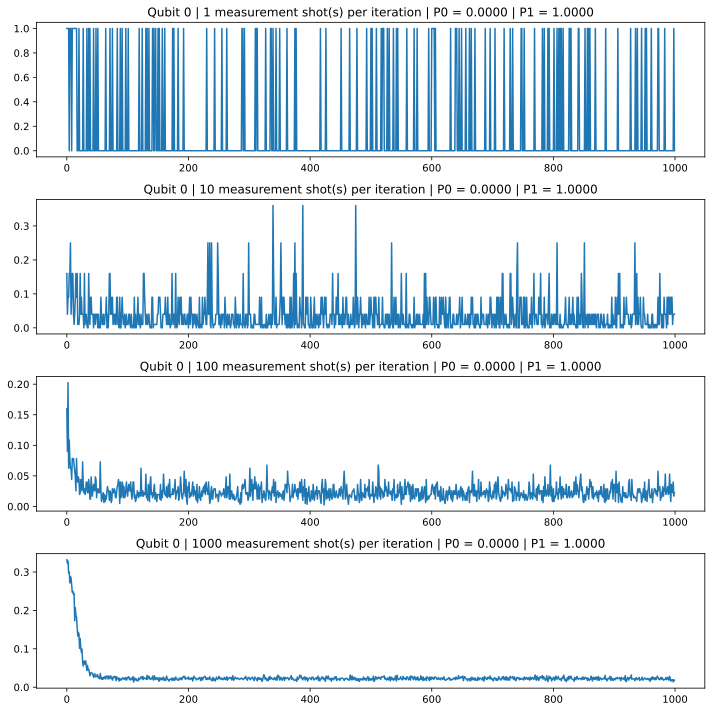

In [23]:
plot_graphs(q1)

<a id='six'></a>
## 6. Complete Circuit

**Combining both the qubits to get complete circuit**

In [33]:
final_circuits = []
final_results = []

for value in range(4):
    qubit0 = q0[value]
    qubit1 = q1[value]
    final_circuit = circuit(qubit0['angles'], qubit1['angles'])
    final_circuits.append(final_circuit)
    final_results.append(execute(final_circuits, backend=qasm, shots=6000, noise_model=None).result())

### 1 shot per iteration

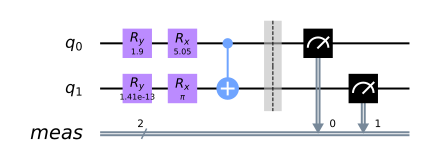

In [34]:
final_circuits[0].draw('mpl')

### 10 shot per iteration

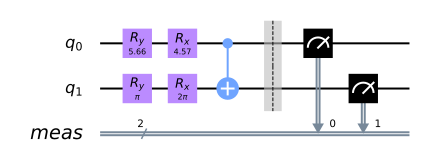

In [35]:
final_circuits[1].draw('mpl')

### 100 shot per iteration

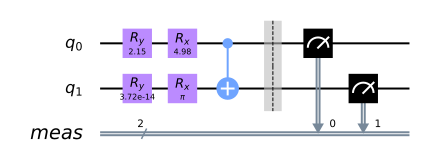

In [36]:
final_circuits[2].draw('mpl')

### 1000 shot per iteration

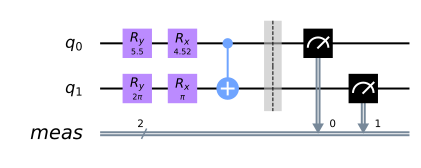

In [37]:
final_circuits[3].draw('mpl')

<a id='seven'></a>
## 7. Comparison

**Condition-5: Compare the results for different numbers of measurements: 1, 10, 100, 1000.**

Visualizing both state's probabilities of all four circuits above in one plot:

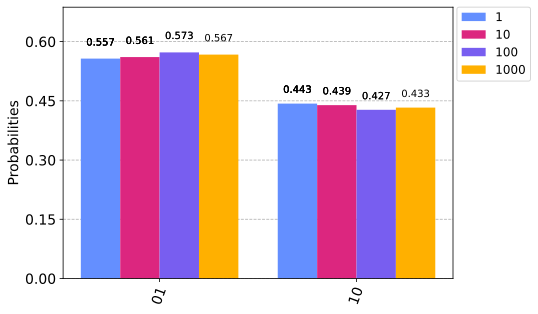

In [38]:
counts = []
for x in range(len(final_circuits)):
    count = final_results[x].get_counts(final_circuits[x])
    counts.append(count)

plot_histogram(counts, legend=['1','10','100','1000'])

### Plotting on Q-sphere

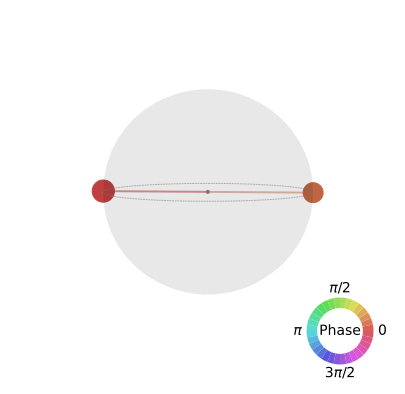

In [43]:
sv = Statevector.from_label('00').evolve(final_circuits[0].remove_final_measurements(inplace=False))
plot_state_qsphere(sv.data)

<a id='summary'></a>
# Summary:

The task asked to implement a parametrized circuit with Rx, Ry and CNOT gates, which is optimized by gradient descent optimizer to produce equal probabilities of $|01\rangle$ and $|01\rangle$ states. I have tried to approach this problem by visualizing the original bell state using standard approach, i.e. with Hadamard, X and CNOT gates. Then I have tried to find to get equal probability of states using a set of Rx, Ry and CNOT gates. The approach was to make a combination of Ry and Rx behave like a Hadamard gate on first qubit and an Rx gate to act as an X gate on second qubit along with a CNOT. After calculating the appropriate angle values, the states are visualized. I have found with calculations that the qubits are separable and can be treated separable. The next step deals with a parametrized circuit that takes in random theta values for each qubit. I have implemented gradient descent optimizer from scratch and have calculated all the cost functions, partial derivatives and probabilities and have used the formulae in the implemented functions. There is an angle_optimizer function that uses Gradient Descent to optimize angle values and reduce costs. The execution is done using qasm simulator for each qubit. At last both qubits are combined together to get the complete circuit and the measurement is taken for shots = 1, 10, 100 and 1000 shots for each 1000 steps for each qubit and 6000 shots for the complete circuit. The final four circuits with optimized theta values from each shot values (i.e. 1, 10, 100 and 1000) have been visualized and their measurements have been plotted on a histogram for visual comparison.

In [62]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}

<a id='ref'></a>
# References:

01. Abraham Asfaw, Luciano Bello, Yael Ben-Haim, Sergey Bravyi, Nicholas Bronn, Lauren Capelluto, Almudena Carrera Vazquez, Jack Ceroni, Richard Chen, Albert Frisch, Jay Gambetta, Shelly Garion, Leron Gil, Salvador De La Puente Gonzalez, Francis Harkins, Takashi Imamichi, David McKay, Antonio Mezzacapo, Zlatko Minev, Ramis Movassagh, Giacomo Nannicni, Paul Nation, Anna Phan, Marco Pistoia, Arthur Rattew, Joachim Schaefer, Javad Shabani, John Smolin, Kristan Temme, Madeleine Tod, Stephen Wood, James Wootton. (2020). Learn Quantum Computation Using Qiskit. http://community.qiskit.org/textbook [Ch: 1.3, 1.4, 2.2]
02. Goodfellow, I., Bengio, Y., Courville, A., & Bengio, Y. (2016). Deep learning (Vol. 1). Cambridge: MIT press.
03. Kshitij Sirohi. (2019). Beginner: Cost Function and Gradient Descent. https://towardsdatascience.com/machine-leaning-cost-function-and-gradient-descend-75821535b2ef
04. Mitarai, K., Negoro, M., Kitagawa, M., & Fujii, K. (2018). Quantum circuit learning. Physical Review A, 98(3), 032309.
05. Sim, S., Johnson, P. D., & Aspuru‐Guzik, A. (2019). Expressibility and Entangling Capability of Parameterized Quantum Circuits for Hybrid Quantum‐Classical Algorithms. Advanced Quantum Technologies, 2(12), 1900070.
06. Benedetti, M., Lloyd, E., Sack, S., & Fiorentini, M. (2019). Parameterized quantum circuits as machine learning models. Quantum Science and Technology, 4(4), 043001.

### Additional tools used as help while preparing this notebook:     
07. IBM Quantum Experience: Circuit Composer. https://quantum-computing.ibm.com/composer/
08. LaTex Equation Editor: https://www.tutorialspoint.com/latex_equation_editor.htm

# Thank You QOSF for a wonderful opportunity to learn!

Regards,   
Pragya Katyayan.